
## MECHENG / CHEMENG 789 Assignment 1 (Tensorflow 2.1)

*This notebook is modified for tensorflow 2.1, NOT tested on Colab.*

Yixin (Elliott) Huangfu

Complete the attached jupyter notebooks and share your observation on the transfer learning.

In this script, weights from a VGG16 image classification network will be resued. Three settings of transfer learning will be compared.

In [1]:
# This script runs in tensorflow 2.0
import os
import tensorflow.keras
import numpy as np
#from PIL import Image
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from tensorflow.keras import backend as k
#from keras.utils import np_utils
#from keras.optimizers import adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
#from sklearn.cross_validation import train_test_split
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Convolution2D,MaxPooling2D

In [2]:
pp='./'
train_path=pp+'cat-and-dog/training_set/'
valid_path=pp+'cat-and-dog/valid_set/'
test_path=pp+'cat-and-dog/test_set/'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=32,
               color_mode="rgb")
valid_batches=datagen.flow_from_directory(
               valid_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=32,
               color_mode="rgb")
test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=4,
               color_mode="rgb")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Build VGG16 model-Sequential

In this section, the top layer of a VGG16 is replaced with 2 units.

VGG16 works with activation="softmax" which does not works here.

In [4]:
#vgg16_model=keras.applications.vgg16.VGG16()
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', input_shape = (224,224,3))

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

vgg16 is a model not a sequential model. It needs to be transformed to a sequential model.
Sequential model create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

In [5]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [6]:
model=Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    model.trainable=False

Remove the last layer of 1000 categories and add the current selection

In [7]:
model.add(Dense(units=2))
model.add(Activation(tf.nn.softmax))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                #steps_per_epoch=4,#train_batches.samples(8005)/train_batches.batch_size(50),
                #validation_steps=4,#valid_batches.samples/valid_batches.batch_size,
                verbose=1,
                #shuffle=False,
                epochs=5)

Epoch 1/5
251/251 [==============================] - 80s 318ms/step - loss: 0.3902 - accuracy: 0.8264 - val_loss: 0.3082 - val_accuracy: 0.8695
Epoch 2/5
251/251 [==============================] - 80s 318ms/step - loss: 0.2896 - accuracy: 0.8753 - val_loss: 0.2599 - val_accuracy: 0.8922
Epoch 3/5
251/251 [==============================] - 80s 318ms/step - loss: 0.2789 - accuracy: 0.8748 - val_loss: 0.2559 - val_accuracy: 0.8888
Epoch 4/5
251/251 [==============================] - 80s 320ms/step - loss: 0.2643 - accuracy: 0.8848 - val_loss: 0.2530 - val_accuracy: 0.8913
Epoch 5/5
251/251 [==============================] - 80s 318ms/step - loss: 0.2499 - accuracy: 0.8904 - val_loss: 0.2399 - val_accuracy: 0.8977


## Prediction

In [11]:
# display the result on test batches
test_batches.batch_size = 20     # process all 20 images together
images, labels = next(test_batches) # take all 20 out
test_pred = model.predict(images).round()

from sklearn.metrics import accuracy_score, confusion_matrix

test_acc = accuracy_score(labels[:,0], test_pred[:,0].round(), normalize=True)
print('Accuracy on {} test samples: {:.1%}'.format(test_batches.batch_size, test_acc))

conf_mtx = confusion_matrix(labels[:,0], test_pred[:,0].round())
print('Confusion matrix on test samples:\n', conf_mtx)

Accuracy on 20 test samples: 95.0%
Confusion matrix on test samples:
 [[ 9  1]
 [ 0 10]]


Class labels: 1-dog, 0-cat


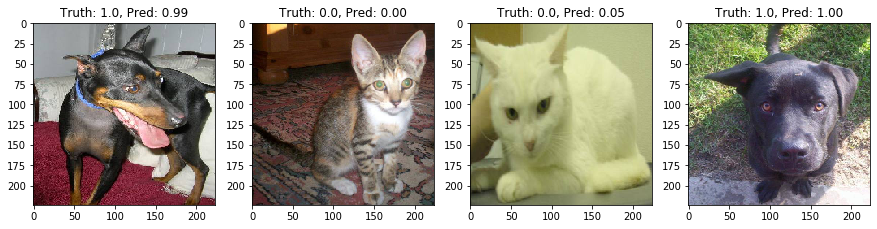

In [12]:
# display predictions
images, labels = next(test_batches)
pred = model.predict(images)
plt.figure(figsize=(15,9))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i,:,:,:])
    plt.title('Truth: {:.1f}, Pred: {:.2f}'.format(labels[i,0], pred[i,0]))
print('Class labels: 1-dog, 0-cat')

# Build VGG16 model-Freeze layers

In this section, more top layers are swapped. However, if trainable parameters are too many, a small dataset may not be able to make training converge.

In [21]:
#vgg16_model=keras.applications.vgg16.VGG16()
#include_top=False ---> exclude the last layer of the VGG model.
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', input_shape = (224,224,3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg16_model.layers])

In [22]:
from tensorflow.keras import Model

x = layer_dict['fc1'].output

x = Dense(units=6)(x)
x = Dropout(0.2)(x)
out = Dense(units=2,activation='softmax')(x)

custom_model = Model(inputs=vgg16_model.input, outputs=out)

# Make sure that the pre-trained bottom layers are not trainable
for l in custom_model.layers[:-3]:
    l.trainable = False

In [23]:
custom_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
custom_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
custom_model.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                #steps_per_epoch=4,#train_batches.samples(8005)/train_batches.batch_size(50),
                #validation_steps=4,#valid_batches.samples/valid_batches.batch_size,
                verbose=1,
                #shuffle=False,
                epochs=5)

Epoch 1/5
251/251 [==============================] - 86s 344ms/step - loss: 0.7338 - accuracy: 0.7565 - val_loss: 0.3408 - val_accuracy: 0.8428
Epoch 2/5
251/251 [==============================] - 86s 343ms/step - loss: 0.3272 - accuracy: 0.8556 - val_loss: 0.2629 - val_accuracy: 0.8903
Epoch 3/5
251/251 [==============================] - 87s 346ms/step - loss: 0.3269 - accuracy: 0.8643 - val_loss: 0.2876 - val_accuracy: 0.8720
Epoch 4/5
251/251 [==============================] - 86s 342ms/step - loss: 0.2846 - accuracy: 0.8854 - val_loss: 0.2484 - val_accuracy: 0.8903
Epoch 5/5
251/251 [==============================] - 86s 343ms/step - loss: 0.2858 - accuracy: 0.8838 - val_loss: 0.3016 - val_accuracy: 0.8705


## Prediction

In [25]:
# display the result on test batches
test_batches.batch_size = 20     # process all 20 images together
images, labels = next(test_batches) # take all 20 out
test_pred = custom_model.predict(images).round()

from sklearn.metrics import accuracy_score, confusion_matrix

test_acc = accuracy_score(labels[:,0], test_pred[:,0].round(), normalize=True)
print('Accuracy on {} test samples: {:.1%}'.format(test_batches.batch_size, test_acc))

conf_mtx = confusion_matrix(labels[:,0], test_pred[:,0].round())
print('Confusion matrix on test samples:\n', conf_mtx)

Accuracy on 20 test samples: 95.0%
Confusion matrix on test samples:
 [[ 9  1]
 [ 0 10]]


Class labels: 1-dog, 0-cat


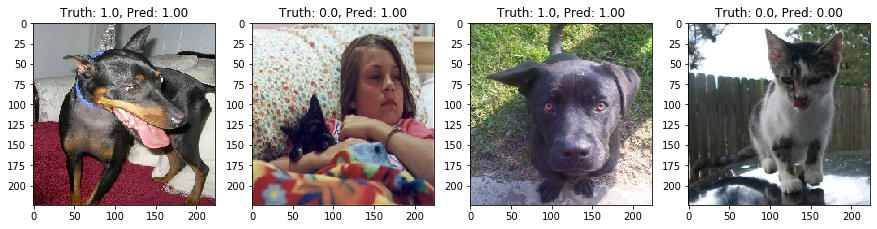

In [26]:
# display predictions
test_batches.batch_size = 4   # display 4 images each time.
images, labels = next(test_batches)
pred = custom_model.predict(images).round()
plt.figure(figsize=(15,9))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i,:,:,:])
    plt.title('Truth: {:.1f}, Pred: {:.2f}'.format(labels[i,0], pred[i,0]))
print('Class labels: 1-dog, 0-cat')

# Build VGG16 model-Initial weight

In [27]:
#keras.applications.vgg16.VGG16()
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

for layer in vgg_model.layers[:5]:
    layer.trainable = True

#for layer in vgg_model.layers:
#    print(layer, layer.trainable)   

In [28]:
#Adding custom Layers 
from tensorflow.keras import Model

x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = vgg_model.input, outputs = predictions)

# Do not forget to compile it
model_final.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

model_final.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [29]:
# With 21 million trainable parameters, the training won't converge
model_final.fit(  
                train_batches,
                validation_data=valid_batches,
                #steps_per_epoch=4,#train_batches.samples/train_batches.batch_size,,
                #validation_steps=4,#valid_batches.samples/valid_batches.batch_size,,
                verbose=1,
                #shuffle=False, 
                epochs=5)

Train for 251 steps, validate for 64 steps
Epoch 1/5
251/251 [==============================] - 84s 336ms/step - loss: 0.7369 - accuracy: 0.5007 - val_loss: 0.6934 - val_accuracy: 0.4998
Epoch 2/5
251/251 [==============================] - 81s 323ms/step - loss: 0.6935 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 3/5
251/251 [==============================] - 81s 322ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 4/5
251/251 [==============================] - 85s 338ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 5/5
251/251 [==============================] - 82s 327ms/step - loss: 0.6933 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.4998


## Prediction

In [30]:
# display the result on test batches
test_batches.batch_size = 20     # process all 20 images together
images, labels = next(test_batches) # take all 20 out
test_pred = model_final.predict(images).round()

from sklearn.metrics import accuracy_score, confusion_matrix

test_acc = accuracy_score(labels[:,0], test_pred[:,0].round(), normalize=True)
print('Accuracy on {} test samples: {:.1%}'.format(test_batches.batch_size, test_acc))

conf_mtx = confusion_matrix(labels[:,0], test_pred[:,0].round())
print('Confusion matrix on test samples:\n', conf_mtx)

Accuracy on 20 test samples: 50.0%
Confusion matrix on test samples:
 [[10  0]
 [10  0]]


Class labels: 1-dog, 0-cat


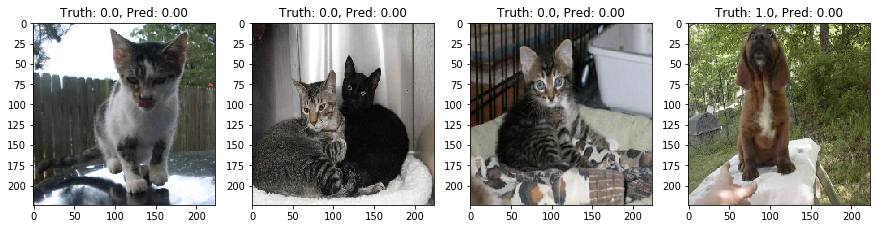

In [31]:
# display predictions
test_batches.batch_size = 4   # display 4 images each time.
images, labels = next(test_batches)
pred = model_final.predict(images).round()
plt.figure(figsize=(15,9))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i,:,:,:])
    plt.title('Truth: {:.1f}, Pred: {:.2f}'.format(labels[i,0], pred[i,0]))
print('Class labels: 1-dog, 0-cat')

# Data Augmentation (Not Implemented yet)

Data Augmentation occures when creating new data with modification.
Filpp, Rotate, Zoom,Color change,Cropping

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc,ndimage
import keras
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator

In [0]:
gen=ImageDataGenerator(rotation_range=10,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.15,
                       zoom_range=0.1,channel_shift_range=10,
                       horizontal_flip=True)

In [0]:
import cv2
image_path='/Users/atousa/Desktop/McMaster/BDA-102/Neural_network/data/cat-and-dog/dog.6.jpg'

In [0]:
image=cv2.imread(image_path)

In [0]:
np.shape(image)

In [0]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,0], cmap='gray')
plt.show()

generate batches of image

In [0]:
np.shape(image)

In [0]:
image = np.moveaxis(image, -1, 0)
image.shape

In [0]:
image_batch = image.reshape((1,) + image.shape)

In [0]:
np.shape(image_batch)

Get 10 sample of the batches

In [0]:
aug_iter=gen.flow(image_batch, batch_size=2)

In [0]:
aug_images=[next(aug_iter)[0].astype(np.uint8) for i in range(10)]
np.shape(aug_images)

In [0]:
for i in range(0,10):
    img = aug_images[i]
    plt.imshow(img[1,:,:].astype('uint8'), cmap='gray')
    plt.show()    